In [246]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import pickle

import xgboost as xgb 
from xgboost import plot_importance

In [247]:
df = pd.read_csv("land-temperature.csv")
df = df[df["Country"] == "Indonesia"]


df = df.drop("AverageTemperatureUncertainty", axis="columns")
df["AverageTemperature"] = df["AverageTemperature"].fillna(df.AverageTemperature.mean())

In [248]:
df = df.set_index("dt")
df.index = pd.to_datetime(df.index)

df = df[df.index > '1983-01-01']

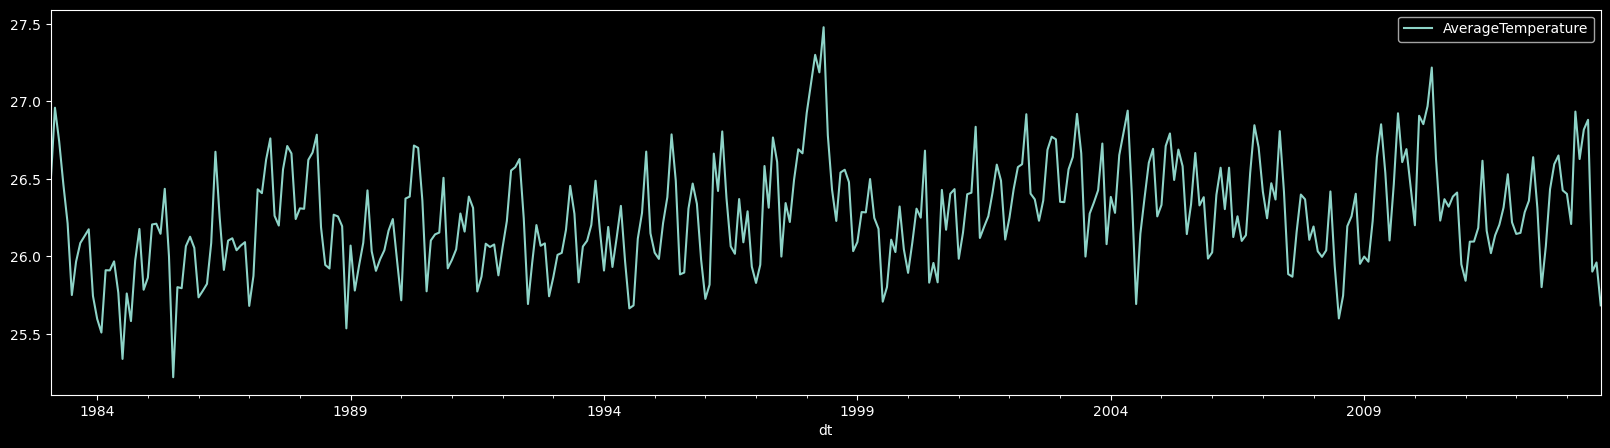

In [249]:
df.plot(figsize=(20, 5))
plt.show()

<Axes: xlabel='dt'>

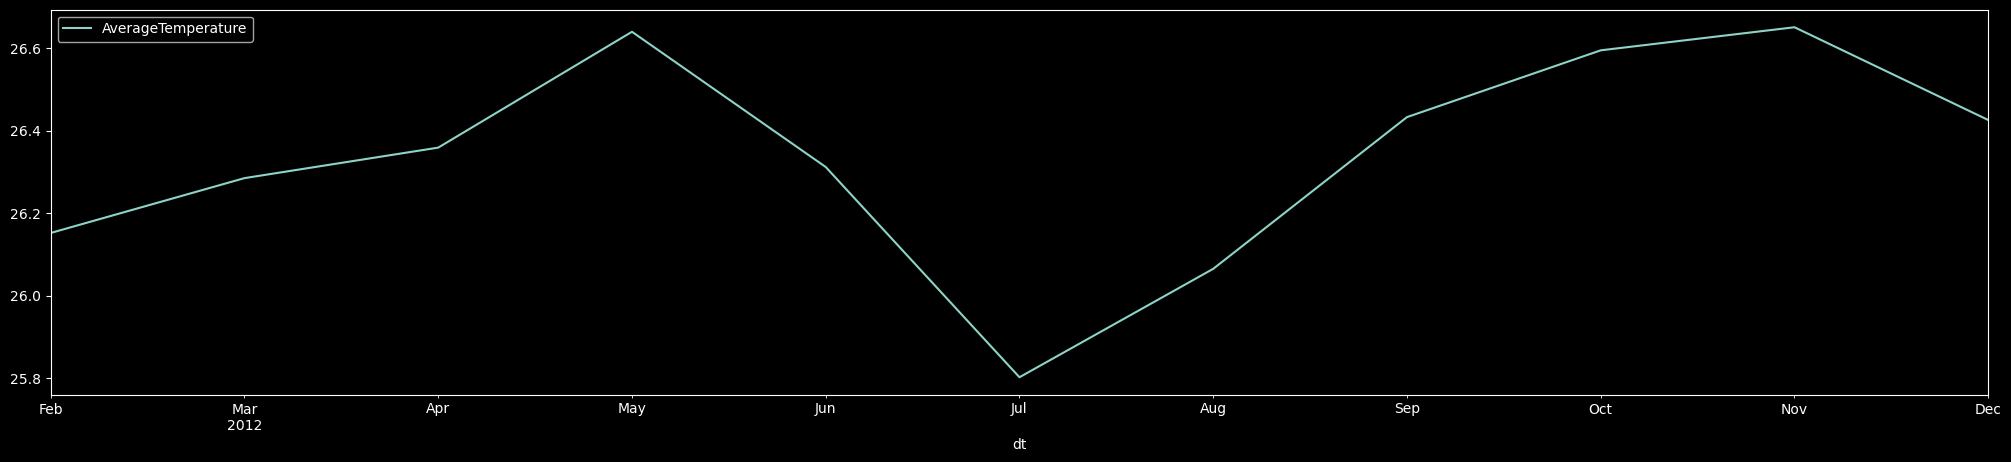

In [250]:
df.loc[(df.index > '2012-01-01') & (df.index < '2013-01-01')].plot(figsize=(25,5))

<Axes: xlabel='dt'>

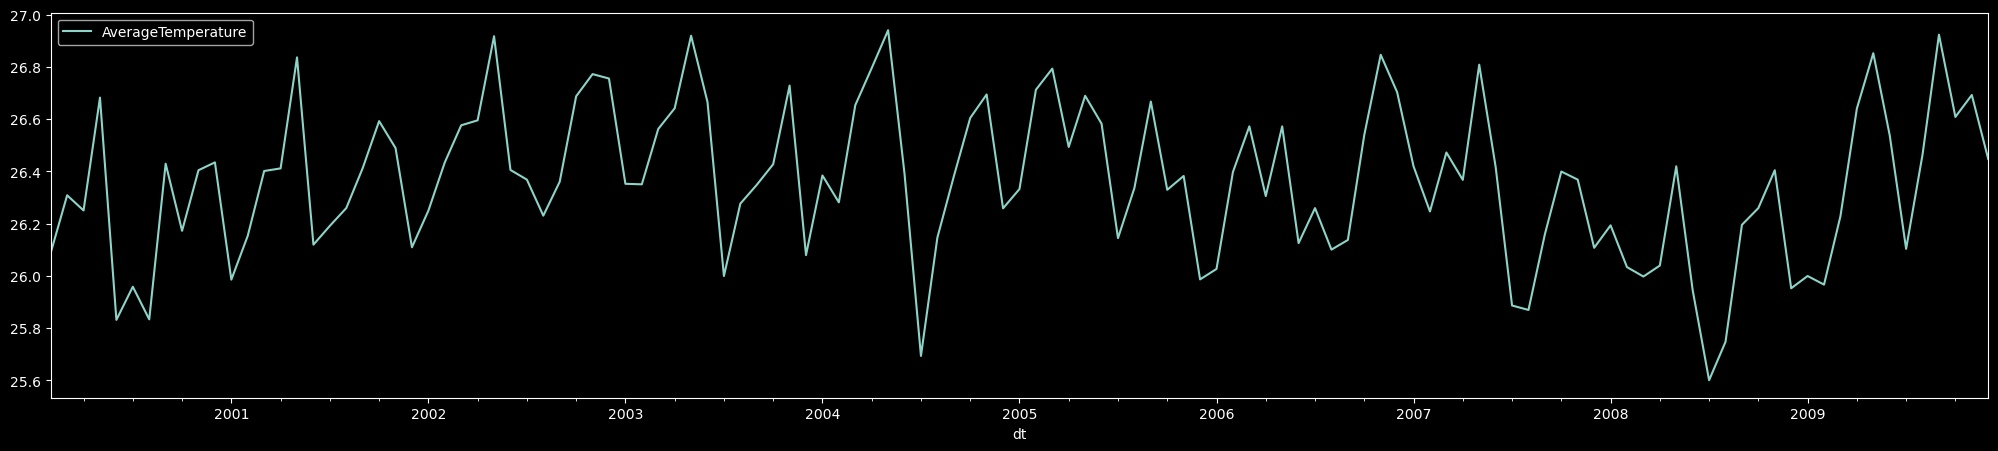

In [251]:
df.loc[(df.index > '2000-01-01') & (df.index < '2010-01-01')].plot(figsize=(25,5))

In [252]:
def create_features(df, label=None):
    df['date'] = df.index
 
    df["month"] = df["date"].dt.month
    df['year'] = df['date'].dt.year
    
    
    X = df[['month', 'year']]
    if label:
        y = df[label]
        return X, y
    return X

In [253]:
split_date = '2005-01-01'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

X_train, y_train = create_features(train, label='AverageTemperature')
X_test, y_test = create_features(test, label='AverageTemperature')

In [254]:
reg = xgb.XGBRegressor(n_estimators=10000, learning_rate=.018, max_depth=7)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

c:\Users\hilla\anaconda3\envs\machine\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.018, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

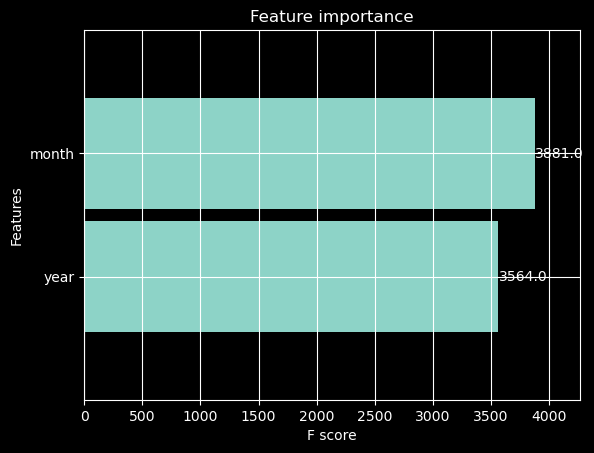

In [255]:
plot_importance(reg, height=0.9)

<Axes: xlabel='dt'>

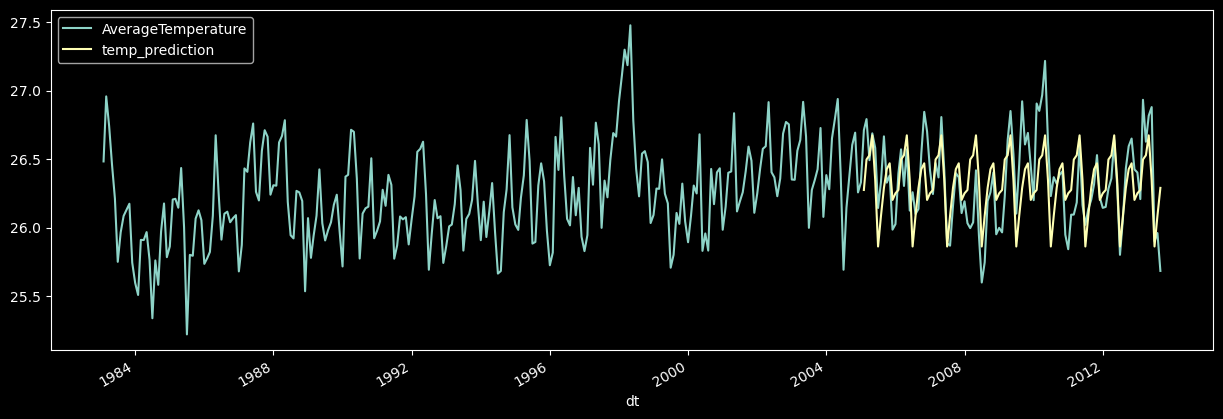

In [256]:
test['temp_prediction'] = reg.predict(X_test)
temp_all = pd.concat([test, train], sort=False)

temp_all[["AverageTemperature", "temp_prediction"]].plot(figsize=(15, 5))

<Axes: xlabel='dt'>

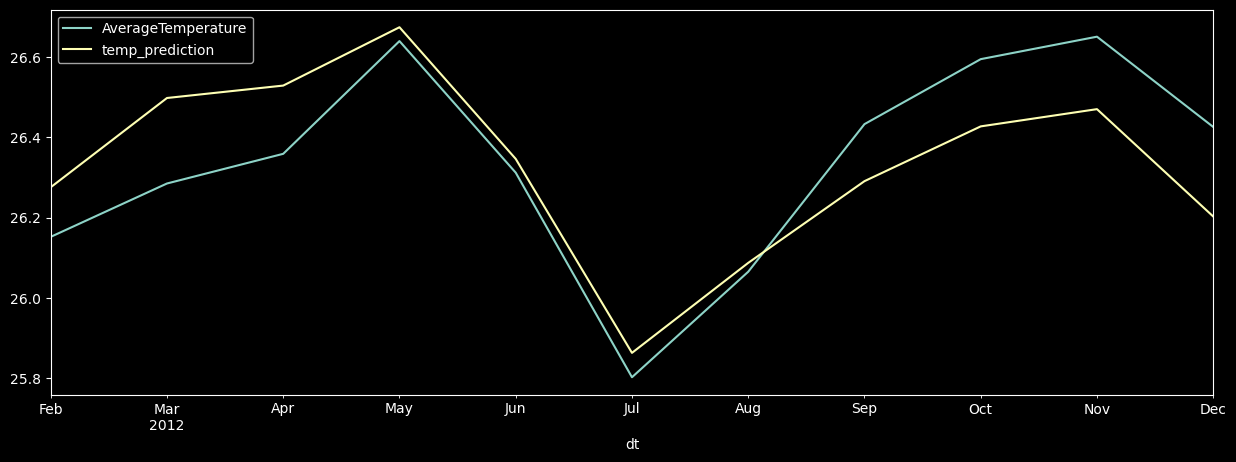

In [267]:
tempyear = temp_all[(temp_all.index > '2012-01-01') & (temp_all.index < '2013-01-01')]
tempyear[["AverageTemperature", "temp_prediction"]].plot(figsize=(15, 5))

In [264]:
def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae(y_test, reg.predict(X_test))

0.7819443436913891

In [265]:
with open('xgboost.pkl', 'wb') as f:
    pickle.dump(reg, f)